4변수 + 이상치제거전

■ sklearn LinearRegression 계수
    변수            계수
 const  88691.611222
   매출액  90081.455004
1인당순이익 -10740.911694
 D/E비율    295.246977
총자산수익률   -813.931326

■ statsmodels OLS Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     123.6
Date:                Mon, 19 May 2025   Prob (F-statistic):           1.08e-78
Time:                        14:28:24   Log-Likelihood:                -8654.1
No. Observations:                 664   AIC:                         1.732e+04
Df Residuals:                     659   BIC:                         1.734e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    st

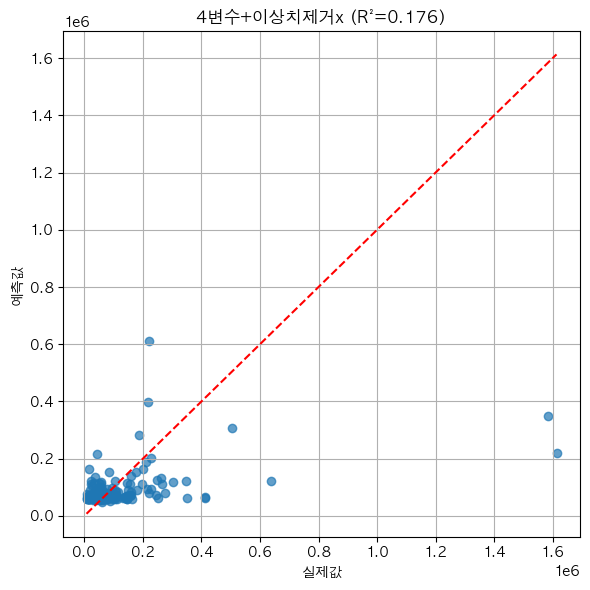

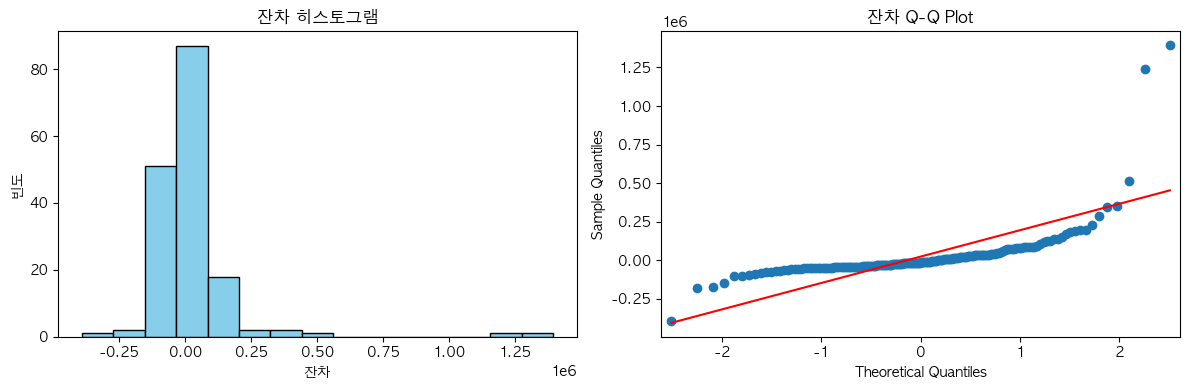

In [3]:
import warnings
import matplotlib as mpl
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 0. 설정
file_path    = "../연관분석/입주공장_면적x평당매매가추가_output.xlsx"
input_cols   = ['매출액', '1인당순이익', 'D/E비율', '총자산수익률']
target_col   = '면적 * 평당매매가'
threshold_r2 = 0.3

# 1. 데이터 로드 및 정제
df = pd.read_excel(file_path, engine="openpyxl")
for col in input_cols + [target_col]:
    s = df[col].astype(str).str.replace(r"[^0-9\.-]+", "", regex=True)
    s = s.str.replace(r"^[-\.]+$", "", regex=True).replace("", np.nan)
    df[col] = pd.to_numeric(s, errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=input_cols + [target_col])

# 2. 스케일링
scaler   = StandardScaler()
X_all    = scaler.fit_transform(df[input_cols])
y_all    = df[target_col].values

# 3. 이상치 순차 제거 (생략되었다고 가정)
# ... (Outlier removal logic) ...

# 4. 최종 데이터 세트 (current_X, current_y) 사용
# 여기서는 간단히 전체 데이터 이용
current_X, current_y = X_all, y_all

# 5. 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    current_X, current_y, test_size=0.2, random_state=42
)

# 6. sklearn 회귀 학습 및 계수
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 회귀 계수 출력
coef_df = pd.DataFrame({
    '변수': ['const'] + input_cols,
    '계수': np.concatenate(([model.intercept_], model.coef_))
})
print("■ sklearn LinearRegression 계수")
print(coef_df.to_string(index=False))

# 7. statsmodels OLS 분석
X_sm = sm.add_constant(X_train)
ols_sm = sm.OLS(y_train, X_sm).fit()

# summary 출력
print("\n■ statsmodels OLS Summary")
print(ols_sm.summary())

# 8. 추가 통계량: VIF
vif_data = pd.DataFrame({
    'variable': ['const'] + input_cols,
    'VIF': [variance_inflation_factor(np.column_stack((np.ones(len(X_train)), X_train)), i)
            for i in range(X_train.shape[1]+1)]
})
print("\n■ VIF (다중공선성 지수)")
print(vif_data.to_string(index=False))

# 9. 주요 진단 통계량
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
resid = y_test - y_pred

print(f"\n■ 주요 성능 지표\n R²: {r2:.4f}\n RMSE: {rmse:.2f}")
print(f" Shapiro-Wilk p-value: {stats.shapiro(resid)[1]:.4f}")
bp_test = het_breuschpagan(resid, sm.add_constant(X_test))
print(f" Breusch-Pagan p-value: {bp_test[1]:.4f}")
print(f" Durbin-Watson stat: {durbin_watson(resid):.4f}")

# ...existing code...

# 10. 산점도: 예측 vs 실제
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title(f"4변수+이상치제거x (R²={r2:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

# 잔차 히스토그램과 Q-Q plot도 함께 보고 싶다면 아래 코드도 추가하세요.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(resid, bins=15, color='skyblue', edgecolor='k')
axes[0].set_title("잔차 히스토그램")
axes[0].set_xlabel("잔차")
axes[0].set_ylabel("빈도")
sm.qqplot(resid, line='s', ax=axes[1])
axes[1].set_title("잔차 Q-Q Plot")
plt.tight_layout()
plt.show()

4변수 + 이상치제거후

Removed outliers: (288, 81)

■ 회귀 계수
    변수           계수
 const 48765.916076
   매출액 47731.834028
1인당순이익 -3832.167358
 D/E비율 -2819.855151
총자산수익률   907.635275

■ statsmodels OLS Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     77.64
Date:                Mon, 19 May 2025   Prob (F-statistic):           1.79e-49
Time:                        14:31:33   Log-Likelihood:                -4883.0
No. Observations:                 433   AIC:                             9776.
Df Residuals:                     428   BIC:                             9796.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    s

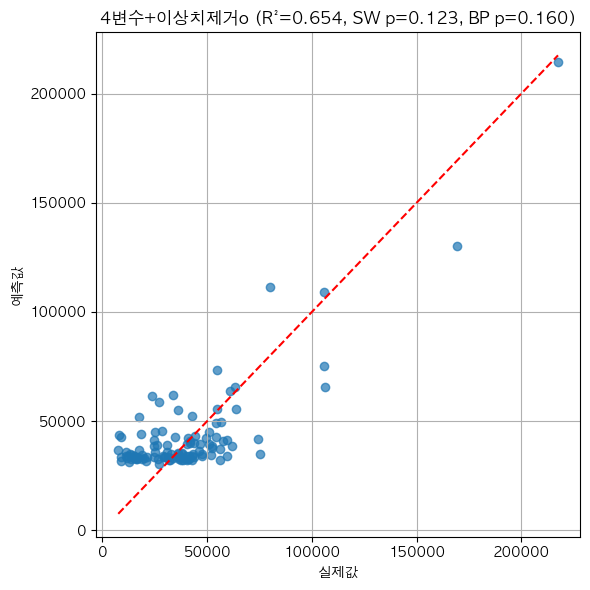

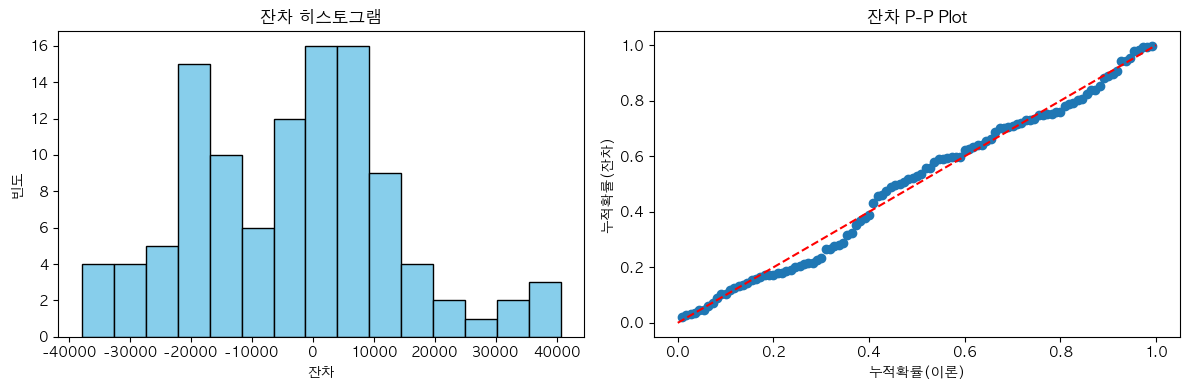

In [7]:
import warnings
import matplotlib as mpl
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# 0. 설정
file_path      = "../연관분석/입주공장_면적x평당매매가추가_output.xlsx"
input_cols     = ['매출액', '1인당순이익', 'D/E비율', '총자산수익률']
target_col     = '면적 * 평당매매가'
min_obs        = 20
r2_thresh      = 0.65
shapiro_thresh = 0.01
bp_thresh      = 0.01

# 1. 데이터 로드 & 정제
df = pd.read_excel(file_path, engine="openpyxl")
for col in input_cols + [target_col]:
    s = df[col].astype(str).str.replace(r"[^0-9\.-]+", "", regex=True)
    s = s.str.replace(r"^[-\.]+$", "", regex=True).replace("", np.nan)
    df[col] = pd.to_numeric(s, errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=input_cols + [target_col])

# 2. 스케일링
scaler   = StandardScaler()
X_all    = scaler.fit_transform(df[input_cols])
y_all    = df[target_col].values

# 3. 이상치 순차 제거
removed     = pd.DataFrame(columns=df.columns)
current_df  = df.copy()
current_X   = X_all.copy()
current_y   = y_all.copy()

while len(current_df) > min_obs:
    X_tr, X_te, y_tr, y_te = train_test_split(current_X, current_y, test_size=0.2, random_state=42)
    model = LinearRegression().fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    resid = y_te - y_pred
    _, p_shapiro = stats.shapiro(resid)
    X_te_sm = sm.add_constant(X_te)
    _, p_bp, _, _ = het_breuschpagan(resid, X_te_sm)
    if r2 >= r2_thresh and p_shapiro >= shapiro_thresh and p_bp >= bp_thresh:
        break
    full_pred = model.predict(current_X)
    full_resid = np.abs(current_y - full_pred)
    worst_i = full_resid.argmax()
    worst_idx = current_df.index[worst_i]
    removed = pd.concat([removed, current_df.loc[[worst_idx]]], ignore_index=True)
    current_df = current_df.drop(index=worst_idx)
    current_X = np.delete(current_X, worst_i, axis=0)
    current_y = np.delete(current_y, worst_i, axis=0)

# 4. 제거된 이상치 저장
removed.to_csv("removed_until_diagnostics.csv", index=False)
print("Removed outliers:", removed.shape)

# 5. 최종 학습/검증
X_train, X_test, y_train, y_test = train_test_split(current_X, current_y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6. 회귀 계수 출력
coef_df = pd.DataFrame({
    '변수': ['const'] + input_cols,
    '계수': np.concatenate(([model.intercept_], model.coef_))
})
print("\n■ 회귀 계수")
print(coef_df.to_string(index=False))

# 7. statsmodels OLS 상세 분석
X_tr_sm = sm.add_constant(X_train)
X_te_sm = sm.add_constant(X_test)
ols_sm = sm.OLS(y_train, X_tr_sm).fit()
print("\n■ statsmodels OLS Summary")
print(ols_sm.summary())

# 8. VIF 계산
vif_df = pd.DataFrame({
    '변수': ['const'] + input_cols,
    'VIF': [variance_inflation_factor(np.column_stack((np.ones(len(X_train)), X_train)), i)
            for i in range(X_train.shape[1]+1)]
})
print("\n■ VIF (다중공선성 지수)")
print(vif_df.to_string(index=False))

# 9. 주요 진단 통계량
r2_val = r2_score(y_test, y_pred)
rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))
resid_test = y_test - y_pred

print(f"\n■ 주요 성능 지표\n R²: {r2_val:.4f}\n RMSE: {rmse_val:.2f}")
print(f" Shapiro–Wilk p-value: {stats.shapiro(resid_test)[1]:.4f}")
bp = het_breuschpagan(resid_test, X_te_sm)
print(f" Breusch–Pagan p-value: {bp[1]:.4f}")
print(f" Durbin–Watson stat: {durbin_watson(resid_test):.4f}")

# 10. 산점도: 예측 vs 실제
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값"); plt.ylabel("예측값")
plt.title(f"4변수+이상치제거o (R²={r2_val:.3f}, SW p={stats.shapiro(resid_test)[1]:.3f}, BP p={bp[1]:.3f})")
plt.grid(True); plt.tight_layout()
plt.show()

# ...existing code...

# 잔차 히스토그램 & P-P plot만 출력
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. 히스토그램
axes[0].hist(resid_test, bins=15, color='skyblue', edgecolor='k')
axes[0].set_title("잔차 히스토그램")
axes[0].set_xlabel("잔차")
axes[0].set_ylabel("빈도")

# 2. P-P plot
from scipy.stats import norm
resid_sorted = np.sort(resid_test)
n = len(resid_sorted)
probs = np.arange(1, n+1) / (n+1)
theoretical = norm.cdf(resid_sorted, loc=np.mean(resid_test), scale=np.std(resid_test))
axes[1].plot(probs, theoretical, 'o', label='잔차 P-P')
axes[1].plot([0,1], [0,1], 'r--')
axes[1].set_title("잔차 P-P Plot")
axes[1].set_xlabel("누적확률(이론)")
axes[1].set_ylabel("누적확률(잔차)")

plt.tight_layout()
plt.show()


■ 독립변수와 종속변수 간 상관계수(피어슨)
매출액       0.581310
1인당순이익   -0.162778
D/E비율    -0.007152
총자산수익률   -0.008999
Name: 면적 * 평당매매가, dtype: float64


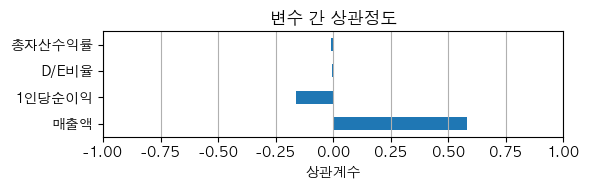

In [8]:
# 각 독립변수와 종속변수 간 상관계수(피어슨) 표 출력
corr_with_target = df[input_cols + [target_col]].corr()[target_col].drop(target_col)
print("\n■ 독립변수와 종속변수 간 상관계수(피어슨)")
print(corr_with_target)

# 시각화 (선택)
plt.figure(figsize=(6, 2))
corr_with_target.plot(kind='barh')
plt.title("변수 간 상관정도")
plt.xlabel("상관계수")
plt.xlim(-1, 1)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

변수2개 + 이상치제거x

■ sklearn LinearRegression 계수
    변수            계수
 const  88292.293445
   매출액  78548.967292
1인당순이익 -10380.423594

■ statsmodels OLS Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     75.16
Date:                Mon, 19 May 2025   Prob (F-statistic):           3.85e-30
Time:                        14:55:17   Log-Likelihood:                -8672.2
No. Observations:                 665   AIC:                         1.735e+04
Df Residuals:                     662   BIC:                         1.736e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025   

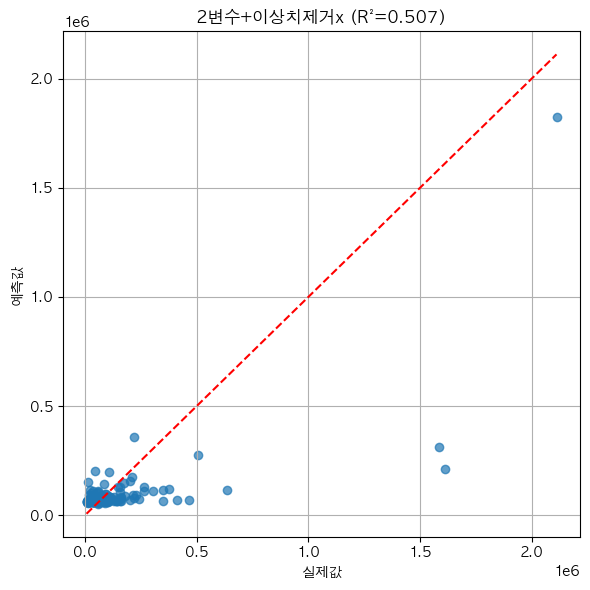

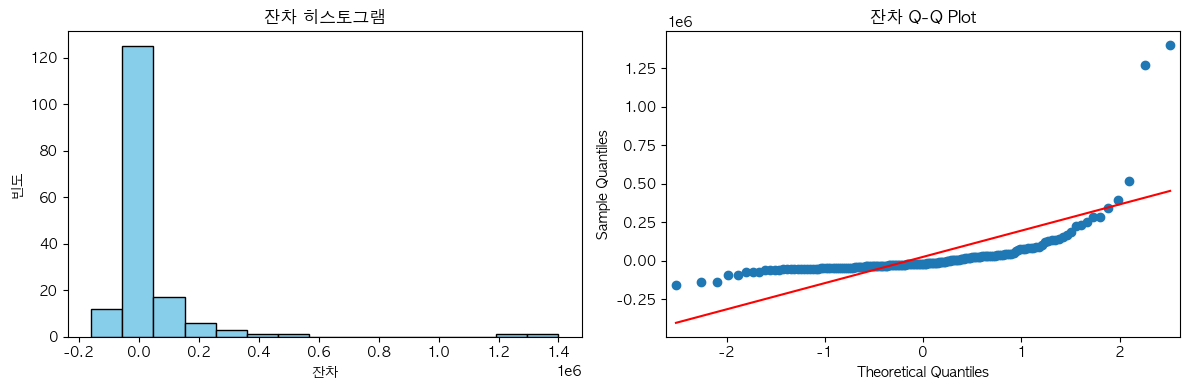

In [10]:
import warnings
import matplotlib as mpl
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 0. 설정
file_path    = "../연관분석/입주공장_면적x평당매매가추가_output.xlsx"
input_cols   = ['매출액', '1인당순이익']
target_col   = '면적 * 평당매매가'
threshold_r2 = 0.3

# 1. 데이터 로드 및 정제
df = pd.read_excel(file_path, engine="openpyxl")
for col in input_cols + [target_col]:
    s = df[col].astype(str).str.replace(r"[^0-9\.-]+", "", regex=True)
    s = s.str.replace(r"^[-\.]+$", "", regex=True).replace("", np.nan)
    df[col] = pd.to_numeric(s, errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=input_cols + [target_col])

# 2. 스케일링
scaler   = StandardScaler()
X_all    = scaler.fit_transform(df[input_cols])
y_all    = df[target_col].values

# 3. 이상치 순차 제거 (생략되었다고 가정)
# ... (Outlier removal logic) ...

# 4. 최종 데이터 세트 (current_X, current_y) 사용
# 여기서는 간단히 전체 데이터 이용
current_X, current_y = X_all, y_all

# 5. 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    current_X, current_y, test_size=0.2, random_state=42
)

# 6. sklearn 회귀 학습 및 계수
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 회귀 계수 출력
coef_df = pd.DataFrame({
    '변수': ['const'] + input_cols,
    '계수': np.concatenate(([model.intercept_], model.coef_))
})
print("■ sklearn LinearRegression 계수")
print(coef_df.to_string(index=False))

# 7. statsmodels OLS 분석
X_sm = sm.add_constant(X_train)
ols_sm = sm.OLS(y_train, X_sm).fit()

# summary 출력
print("\n■ statsmodels OLS Summary")
print(ols_sm.summary())

# 8. 추가 통계량: VIF
vif_data = pd.DataFrame({
    'variable': ['const'] + input_cols,
    'VIF': [variance_inflation_factor(np.column_stack((np.ones(len(X_train)), X_train)), i)
            for i in range(X_train.shape[1]+1)]
})
print("\n■ VIF (다중공선성 지수)")
print(vif_data.to_string(index=False))

# 9. 주요 진단 통계량
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
resid = y_test - y_pred

print(f"\n■ 주요 성능 지표\n R²: {r2:.4f}\n RMSE: {rmse:.2f}")
print(f" Shapiro-Wilk p-value: {stats.shapiro(resid)[1]:.4f}")
bp_test = het_breuschpagan(resid, sm.add_constant(X_test))
print(f" Breusch-Pagan p-value: {bp_test[1]:.4f}")
print(f" Durbin-Watson stat: {durbin_watson(resid):.4f}")

# ...existing code...

# 10. 산점도: 예측 vs 실제
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title(f"2변수+이상치제거x (R²={r2:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

# 잔차 히스토그램과 Q-Q plot도 함께 보고 싶다면 아래 코드도 추가하세요.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(resid, bins=15, color='skyblue', edgecolor='k')
axes[0].set_title("잔차 히스토그램")
axes[0].set_xlabel("잔차")
axes[0].set_ylabel("빈도")
sm.qqplot(resid, line='s', ax=axes[1])
axes[1].set_title("잔차 Q-Q Plot")
plt.tight_layout()
plt.show()

2변수 + 이상치제거o

Removed outliers: (309, 81)

■ 회귀 계수
    변수           계수
 const 47103.193104
   매출액 46061.990677
1인당순이익 -2391.126468

■ statsmodels OLS Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     129.9
Date:                Mon, 19 May 2025   Prob (F-statistic):           1.54e-44
Time:                        15:05:12   Log-Likelihood:                -4677.0
No. Observations:                 418   AIC:                             9360.
Df Residuals:                     415   BIC:                             9372.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025

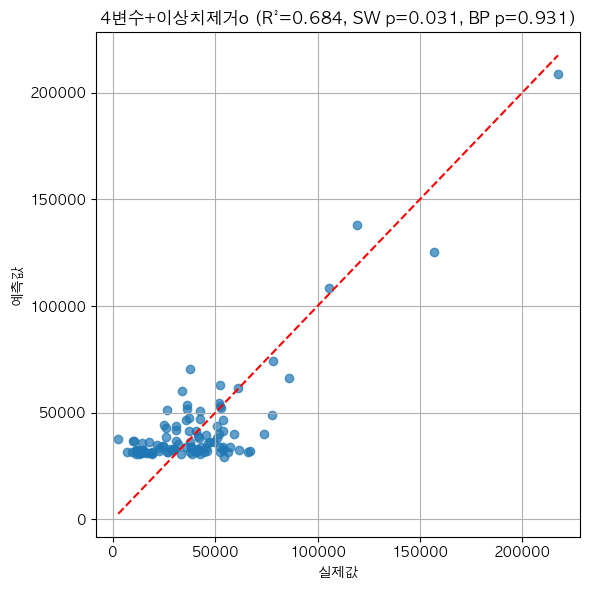

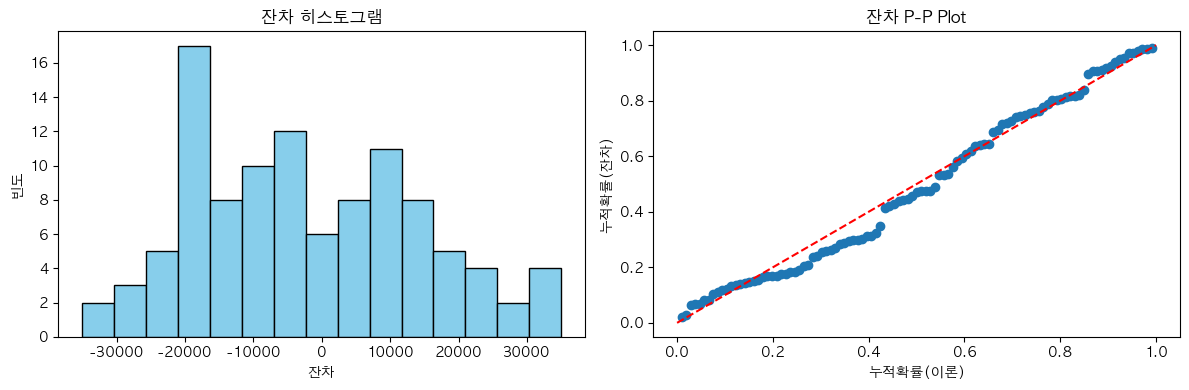

In [11]:
import warnings
import matplotlib as mpl
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# 0. 설정
file_path      = "../연관분석/입주공장_면적x평당매매가추가_output.xlsx"
input_cols     = ['매출액', '1인당순이익']
target_col     = '면적 * 평당매매가'
min_obs        = 20
r2_thresh      = 0.65
shapiro_thresh = 0.01
bp_thresh      = 0.01

# 1. 데이터 로드 & 정제
df = pd.read_excel(file_path, engine="openpyxl")
for col in input_cols + [target_col]:
    s = df[col].astype(str).str.replace(r"[^0-9\.-]+", "", regex=True)
    s = s.str.replace(r"^[-\.]+$", "", regex=True).replace("", np.nan)
    df[col] = pd.to_numeric(s, errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=input_cols + [target_col])

# 2. 스케일링
scaler   = StandardScaler()
X_all    = scaler.fit_transform(df[input_cols])
y_all    = df[target_col].values

# 3. 이상치 순차 제거
removed     = pd.DataFrame(columns=df.columns)
current_df  = df.copy()
current_X   = X_all.copy()
current_y   = y_all.copy()

while len(current_df) > min_obs:
    X_tr, X_te, y_tr, y_te = train_test_split(current_X, current_y, test_size=0.2, random_state=42)
    model = LinearRegression().fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    resid = y_te - y_pred
    _, p_shapiro = stats.shapiro(resid)
    X_te_sm = sm.add_constant(X_te)
    _, p_bp, _, _ = het_breuschpagan(resid, X_te_sm)
    if r2 >= r2_thresh and p_shapiro >= shapiro_thresh and p_bp >= bp_thresh:
        break
    full_pred = model.predict(current_X)
    full_resid = np.abs(current_y - full_pred)
    worst_i = full_resid.argmax()
    worst_idx = current_df.index[worst_i]
    removed = pd.concat([removed, current_df.loc[[worst_idx]]], ignore_index=True)
    current_df = current_df.drop(index=worst_idx)
    current_X = np.delete(current_X, worst_i, axis=0)
    current_y = np.delete(current_y, worst_i, axis=0)

# 4. 제거된 이상치 저장
removed.to_csv("removed_until_diagnostics.csv", index=False)
print("Removed outliers:", removed.shape)

# 5. 최종 학습/검증
X_train, X_test, y_train, y_test = train_test_split(current_X, current_y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6. 회귀 계수 출력
coef_df = pd.DataFrame({
    '변수': ['const'] + input_cols,
    '계수': np.concatenate(([model.intercept_], model.coef_))
})
print("\n■ 회귀 계수")
print(coef_df.to_string(index=False))

# 7. statsmodels OLS 상세 분석
X_tr_sm = sm.add_constant(X_train)
X_te_sm = sm.add_constant(X_test)
ols_sm = sm.OLS(y_train, X_tr_sm).fit()
print("\n■ statsmodels OLS Summary")
print(ols_sm.summary())

# 8. VIF 계산
vif_df = pd.DataFrame({
    '변수': ['const'] + input_cols,
    'VIF': [variance_inflation_factor(np.column_stack((np.ones(len(X_train)), X_train)), i)
            for i in range(X_train.shape[1]+1)]
})
print("\n■ VIF (다중공선성 지수)")
print(vif_df.to_string(index=False))

# 9. 주요 진단 통계량
r2_val = r2_score(y_test, y_pred)
rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))
resid_test = y_test - y_pred

print(f"\n■ 주요 성능 지표\n R²: {r2_val:.4f}\n RMSE: {rmse_val:.2f}")
print(f" Shapiro–Wilk p-value: {stats.shapiro(resid_test)[1]:.4f}")
bp = het_breuschpagan(resid_test, X_te_sm)
print(f" Breusch–Pagan p-value: {bp[1]:.4f}")
print(f" Durbin–Watson stat: {durbin_watson(resid_test):.4f}")

# 10. 산점도: 예측 vs 실제
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값"); plt.ylabel("예측값")
plt.title(f"4변수+이상치제거o (R²={r2_val:.3f}, SW p={stats.shapiro(resid_test)[1]:.3f}, BP p={bp[1]:.3f})")
plt.grid(True); plt.tight_layout()
plt.show()

# ...existing code...

# 잔차 히스토그램 & P-P plot만 출력
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. 히스토그램
axes[0].hist(resid_test, bins=15, color='skyblue', edgecolor='k')
axes[0].set_title("잔차 히스토그램")
axes[0].set_xlabel("잔차")
axes[0].set_ylabel("빈도")

# 2. P-P plot
from scipy.stats import norm
resid_sorted = np.sort(resid_test)
n = len(resid_sorted)
probs = np.arange(1, n+1) / (n+1)
theoretical = norm.cdf(resid_sorted, loc=np.mean(resid_test), scale=np.std(resid_test))
axes[1].plot(probs, theoretical, 'o', label='잔차 P-P')
axes[1].plot([0,1], [0,1], 'r--')
axes[1].set_title("잔차 P-P Plot")
axes[1].set_xlabel("누적확률(이론)")
axes[1].set_ylabel("누적확률(잔차)")

plt.tight_layout()
plt.show()